# Requirements and utils

This section includes all **requirements** to run this notebook: from package instalations and imports to classes and functions.

## Imports and requirements

In [ ]:
!pip install wfdb
!pip install torchmetrics

In [2]:
import os
import ast
import wfdb
import torch
import pickle
import random
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from scipy import signal
from google.colab import drive
from torchmetrics import Accuracy
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pd.options.mode.chained_assignment = None

In [3]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Classes

In [5]:
class CustomDataset(Dataset):
  '''
  Custom class for dataset.

  Params:
  -------
  data_pkl: str
    Path to pickle containing data.
  '''

  def __init__(self, data_pkl):

    with open(data_pkl, 'rb') as f:
      self.X, self.y = pickle.load(f)
    self.X = torch.tensor(self.X).permute(0, 2, 1)  # from [len_dataset, len_signals, num_channels] to [len_dataset, num_channels, len_signals]
    self.y = torch.tensor(self.y)

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):

    return self.X[idx], self.y[idx]

In [6]:
class Net(nn.Module):
  '''
  Custom model which divides input signal in different channels, calculates one
  feature per channel and concatenates them before making the final prediction.
  '''

  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv1d(1, 16, 3, padding=1)
    self.conv2 = nn.Conv1d(8, 32, 3, padding=1)
    self.conv3 = nn.Conv1d(16, 64, 5, padding=2)

    self.fc1 = nn.Linear(4000, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 1)

    self.fc4 = nn.Linear(12, 2)

    self.norm1 = nn.BatchNorm1d(0)

  def forward(self,x):

    # Initialize variable to save input to last fully connected layer
    x_all_channels = torch.zeros([x.shape[0], x.shape[1], 1])  # [batch_size, num_channels, 1]

    # Loop throuh channels to perform feature extraction
    for i in range(x.shape[1]):
      x_channel = x[:, i]
      x_channel = x_channel[:, None, :]
      x_channel = self.channel_feature_extraction(x_channel)
      x_channel = self.channel_fc(x_channel)
      x_all_channels[:, i, :] = x_channel

    # Squeeze last dimension
    x_all_channels = torch.squeeze(x_all_channels).double()

    # Get output probabilities
    x_out = F.log_softmax(self.fc4(x_all_channels), dim=1)

    return x_out

  def channel_feature_extraction(self,x):

    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x,2)
    x = torch.flatten(x, start_dim=1)

    return x

  def channel_fc(self, x):

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

## Functions

In [7]:
def load_metadata(data_dir):
  '''
  Load csv containing metadata for each ECG signal and add corresponding labels.
  In part taken from dataset code example. Only the preprocessing of the diagnostic superclass
  was implemented: from one column containing a list of the conditions found in
  the signal to multiple binary columns, one for each condition, with 1 indicating
  its present and 0 the opposite.
  '''

  # Load ptbxl_database.csv for metadata
  metadata = pd.read_csv(data_dir + 'ptbxl_database.csv')
  metadata.scp_codes = metadata.scp_codes.apply(lambda x: ast.literal_eval(x))

  # Load scp_statements.csv for diagnostic aggregation
  agg_df = pd.read_csv(data_dir + 'scp_statements.csv', index_col=0)
  agg_df = agg_df[agg_df.diagnostic == 1]

  def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

  # Apply diagnostic superclass
  metadata['diagnostic_superclass'] = metadata.scp_codes.apply(aggregate_diagnostic)

  dct = {0: 'NORM', 1: 'MI', 2: 'STTC', 3: 'CD', 4: 'HYP'}

  # Preprocess diagnostic superclass
  encod_list_encod = list()
  for i in metadata['diagnostic_superclass'].keys():
    encod_sub = [list(dct.values()).index(x.strip()) for x in metadata.loc[i,'diagnostic_superclass']] # creating a list of keys, corresponding to coded subtractes
    encod_list_encod.append(encod_sub)
  metadata['diagnostic_superclass_encoded'] = encod_list_encod

  mlb = MultiLabelBinarizer() # Encoding in MultiLabelBinarizer way and split in different columns
  binary_data = mlb.fit_transform(metadata['diagnostic_superclass_encoded'])
  binary_data
  binary_columns = pd.DataFrame(binary_data, index=metadata.index, columns=['NORM', 'MI', 'STTC', 'CD', 'HYP'])
  binary_columns
  metadata = metadata.join(binary_columns, how='inner')
  metadata = metadata.drop(columns=['diagnostic_superclass_encoded'])

  return metadata

def load_data(filename, path):
  '''
  Load one ECG file.
  Adapted from dataset code example.
  '''

  data, meta = wfdb.rdsamp(path + filename)
  return data, meta

def load_all_data(path, metadata):
  '''
  Load and append all ECG files.
  Adapted from dataset code example.
  '''

  data = [wfdb.rdsamp(path + f) for f in metadata.filename_lr]
  data = np.array([signal for signal, meta in data])
  return data

In [8]:
def plot_ecg(data, meta):
  '''
  Function to plot all leads from input ECG data.
  '''

  # Get leads
  leads = meta['sig_name']

  # Create time vector
  time = np.linspace(0, meta['sig_len']/meta['fs'], meta['sig_len'])

  # Plot all leads
  fig, axs = plt.subplots(3, 4)
  fig.set_figheight(8)
  fig.set_figwidth(12)
  pos_x = 0
  pos_y = 0

  for i, lead in enumerate(leads):

    axs[pos_x, pos_y].plot(time, data[:, i])
    axs[pos_x, pos_y].set_title(lead)
    axs[pos_x, pos_y].set_xlabel("Time (s)")
    axs[pos_x, pos_y].set_ylabel(f"Amplitude ({meta['units'][i]})")
    pos_x += 1
    if pos_x == 3:
      pos_x = 0
      pos_y += 1

  plt.tight_layout()
  plt.show()

In [74]:
def calculate_heart_rate(data, meta, threshold=0.6, plot=False):
  '''
  Function to calculate heart rate from ECG signals and plot R-peaks if defined.
  '''

  # Get leads of signal
  leads = meta['sig_name']

  hr_dict = {}

  # Initialize plot
  if plot:
    fig, axs = plt.subplots(3, 4)
    fig.set_figheight(8)
    fig.set_figwidth(12)
    pos_x = 0
    pos_y = 0

  for i, lead in enumerate(leads):

    # Get data from specific lead
    s = data[:, i]

    # Check if R-peaks are positive or negative and calculate them
    if abs(np.max(s)) > abs(np.min(s)):
      height = threshold*np.max(s)
      r_peaks, _ = signal.find_peaks(s, height=height, distance=int(100*0.4))
    else:
      height = abs(threshold*np.min(s))
      r_peaks, _ = signal.find_peaks(-s, height=height, distance=int(100*0.4))

    # Calculate heart rate
    rr_intervals = np.diff(r_peaks) / 100  # Compute RR intervals in seconds
    heart_rate = 60 / np.mean(rr_intervals)  # Compute heart rate in BPM

    hr_dict[lead] = heart_rate

    # Plot signal together with R-peaks for each lead
    if plot:
      axs[pos_x, pos_y].plot(s)
      axs[pos_x, pos_y].plot(r_peaks, s[r_peaks], "x")
      axs[pos_x, pos_y].set_title(lead)
      axs[pos_x, pos_y].set_xlabel("Time (s)")
      axs[pos_x, pos_y].set_ylabel(f"Amplitude ({meta['units'][i]})")
      pos_x += 1
      if pos_x == 3:
        pos_x = 0
        pos_y += 1

  plt.tight_layout()
  plt.show()

  # Print heart rate values
  headers = ['Lead', 'Heart rate']
  print(f'{headers[0]: <10}{headers[1]}')
  for key, value in hr_dict.items():
    print(f'{key: <10}{value}')

  return hr_dict

In [9]:
def get_labels(metadata):
  '''
  Function to return the labels for a specific modeling case:
  normal vs myocardial infarction (0 vs 1).
  '''

  labels = []

  for index, row in metadata.iterrows():

    if row['NORM'] == 1:
      labels.append(0)
    if row['MI'] == 1:
      labels.append(1)

  return labels

In [10]:
def seed_everything(seed):
  '''
  Seed random variables to ensure reproducibility.
  '''

  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = True

seed_everything(123)

In [11]:
def train_dl(model, optimizer, loss_fn, acc_fn, n_epochs, train_loader, val_loader, save_dir):
  '''
  Train pipeline for approach.
  '''

  # Variables to save loss/accuracy values
  all_train_loss = []
  all_train_acc = []
  all_val_loss = []
  all_val_acc = []
  lowest_val_loss = 999
  highest_val_acc = 0

  # Train loop
  for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
      y_pred = model(X_batch)
      loss = loss_fn(y_pred.type(torch.float64), y_batch.type(torch.long))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    # Eval loop
    model.eval()
    with torch.no_grad():

      # For training set
      y_pred_train_final = []
      y_train_final = []
      for X_batch, y_batch in train_loader:
        y_pred_train = model(X_batch)
        y_pred_train_final.extend(y_pred_train)
        y_train_final.extend(y_batch)
      y_pred_train_final = torch.stack(y_pred_train_final)
      train_loss = loss_fn(y_pred_train_final, torch.Tensor(y_train_final).type(torch.long))
      train_acc = acc_fn(torch.argmax(y_pred_train_final, dim=1), torch.Tensor(y_train_final))
      all_train_loss.append(train_loss)
      all_train_acc.append(train_acc)

      # For val set
      y_pred_val_final = []
      y_val_final = []
      for X_batch, y_batch in val_loader:
        y_pred_val = model(X_batch)
        y_pred_val_final.extend(y_pred_val)
        y_val_final.extend(y_batch)
      y_pred_val_final = torch.stack(y_pred_val_final)
      val_loss = loss_fn(y_pred_val_final, torch.Tensor(y_val_final).type(torch.long))
      val_acc = acc_fn(torch.argmax(y_pred_val_final, dim=1), torch.Tensor(y_val_final))
      all_val_loss.append(val_loss)
      all_val_acc.append(val_acc)

      # Save lowest validation loss checkpoint
      if val_loss < lowest_val_loss:
        lowest_val_loss = val_loss
        torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'train_loss': train_loss,
          'train_acc': train_acc,
          'val_loss': val_loss,
          'val_acc': val_acc,
          }, os.path.join(save_dir, 'loss_checkpoint.pt'))

      # Save highest validation accuracy checkpoint
      if val_acc > highest_val_acc:
        highest_val_acc = val_acc
        torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'train_loss': train_loss,
          'train_acc': train_acc,
          'val_loss': val_loss,
          'val_acc': val_acc,
          }, os.path.join(save_dir, 'acc_checkpoint.pt'))

  # Plot train-validation loss values for each epoch
  plt.figure()
  plt.plot(all_train_loss, label='Train')
  plt.plot(all_val_loss, label='Validation')
  plt.legend(loc='best')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

  # Plot train-validation accuracy values for each epoch
  plt.figure()
  plt.plot(all_train_acc, label='Train')
  plt.plot(all_val_acc, label='Validation')
  plt.legend(loc='best')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

  return y_train_final, y_pred_train_final, y_val_final, y_pred_val_final, model

In [12]:
def plot_dl_results(save_path, model, test_loader, acc_fn):
  '''
  Plot results: best train-validation metrics, test accuracy and confusion matrix.
  '''

  # Check best train-validation scores saved in checkpoint
  checkpoint = torch.load(save_path)
  model.load_state_dict(checkpoint['model_state_dict'])
  print('Best epoch:', checkpoint['epoch'])
  print('Train loss:', checkpoint['train_loss'].item())
  print('Train accuracy:', checkpoint['train_acc'].item())
  print('Validation loss:', checkpoint['val_loss'].item())
  print('Validation accuracy:', checkpoint['val_acc'].item(), '\n')

  # Eval loop for test set
  model.eval()
  with torch.no_grad():
    y_pred_test_final = []
    y_test_final = []
    for X_batch, y_batch in test_loader:
      y_pred_test = model(X_batch)
      y_pred_test_final.extend(y_pred_test)
      y_test_final.extend(y_batch)

  # Check accuracy for test set
  y_pred_test_final = torch.stack(y_pred_test_final)
  preds = torch.argmax(y_pred_test_final, dim=1)
  targets = torch.Tensor(y_test_final)
  print('Test accuracy:', float(acc_fn(preds, targets)))

  # Plot confusion matrix
  cm = confusion_matrix(y_test_final, preds)
  ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)

  return model

# Data exploration

This section intended to **explore the data** present in the dataset, along with visualization and heart rate estimation.

**Insights and conclusions:**

* Here I found that each ECG signal can have **multiple labels**, which motivated its separation into multiple binary columns for further processing.

* Two signals were visualized: one for **normal** and one for the **Myocardial Infarction** condition, which showed **clear differences** in some channels, not discarding that some of these differences can be due to baseline wander and noise.

* An initial function to **calculate heart rate** was also developed, which proved able to **correctly estimate it in the majority of the leads in normal conditions** wether the R-peaks are positive or negative. However, in leads where the peaks have varying amplitudes due to baseline wander, this function fails. As expected, in cardiac conditions, this function fails in more leads due to the differences in the signals. Nevertheless, it is an initial attempt that could be improved.

In [13]:
data_dir = '/content/drive/My Drive/Idoven/data/'

# Get metadata and labels
metadata = load_metadata(data_dir)

In [16]:
# Check different labels for each ECG data
metadata['diagnostic_superclass'].value_counts()

[NORM]                 9072
[MI]                   2532
[STTC]                 2401
[CD]                   1708
[MI, CD]               1300
[STTC, HYP]             781
[MI, STTC]              600
[HYP]                   535
[NORM, CD]              407
[]                      405
[MI, STTC, HYP]         361
[CD, HYP]               300
[STTC, CD]              270
[CD, STTC]              201
[MI, HYP]               183
[CD, STTC, HYP]         127
[STTC, MI, CD]          118
[MI, CD, HYP]           117
[CD, MI, STTC]          105
[CD, MI, STTC, HYP]     102
[STTC, CD, HYP]          84
[STTC, MI, CD, HYP]      54
[NORM, STTC]             28
[NORM, STTC, CD]          5
[NORM, CD, HYP]           2
[NORM, HYP]               2
[NORM, MI, CD, HYP]       1
Name: diagnostic_superclass, dtype: int64

Diagnostic: ['NORM']


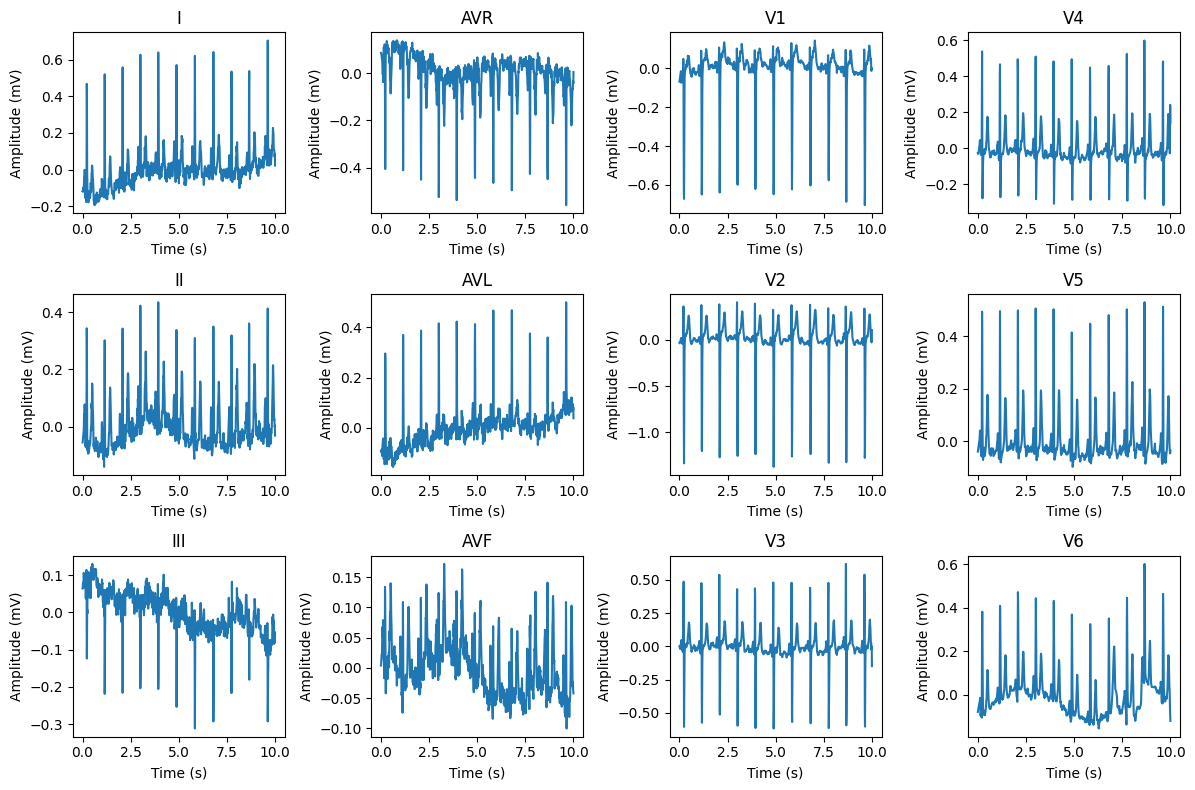

Data issues:
  - baseline drift: nan
  - static noise:  , I-V1,  
  - burst noise: nan
  - electrode problems: nan


In [29]:
# Get first ECG for exploration
filename = metadata.iloc[0].filename_lr
data, meta = load_data(filename, data_dir)
print('Diagnostic:', metadata.iloc[0]['diagnostic_superclass'])
plot_ecg(data, meta)
print('Data issues:')
print('  - baseline drift:', metadata.iloc[0]['baseline_drift'])
print('  - static noise:', metadata.iloc[0]['static_noise'])
print('  - burst noise:', metadata.iloc[0]['burst_noise'])
print('  - electrode problems:', metadata.iloc[0]['electrodes_problems'])

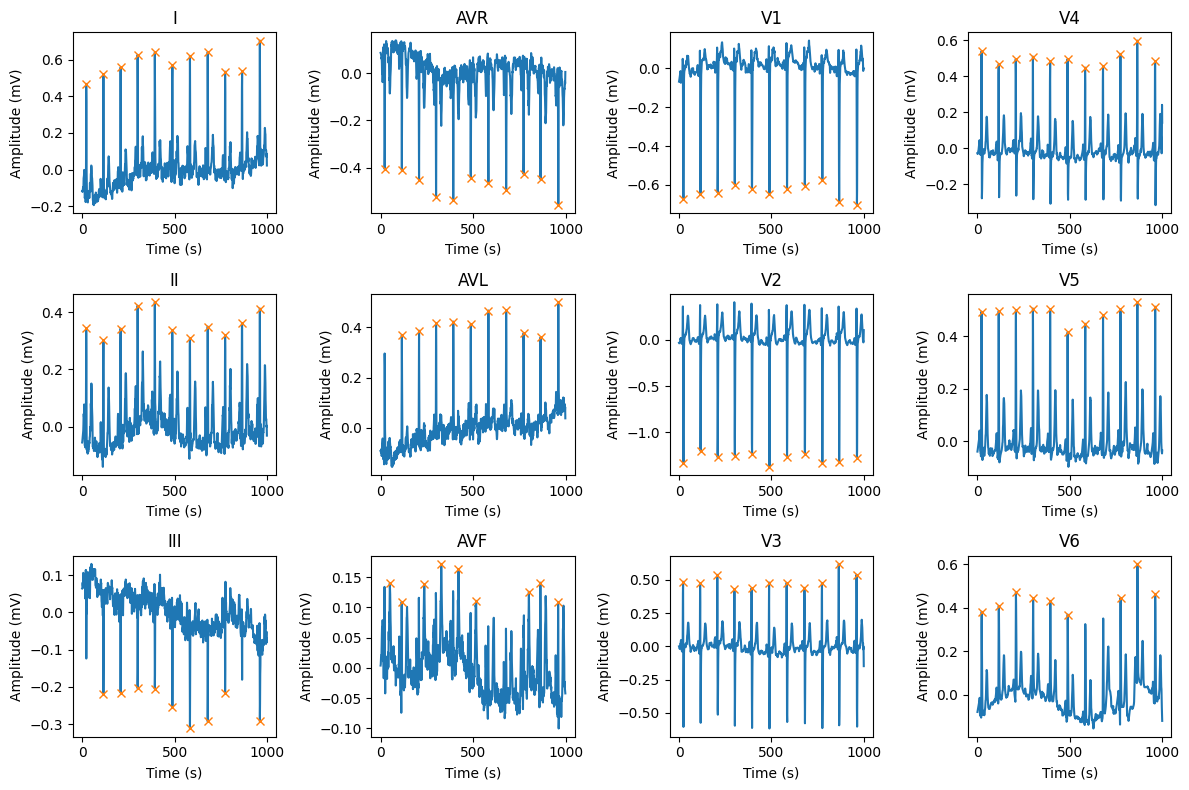

Lead      Heart rate
I         63.897763578274756
II        63.897763578274756
III       56.73758865248227
AVR       63.897763578274756
AVL       63.82978723404255
AVF       52.74725274725274
V1        63.965884861407254
V2        63.965884861407254
V3        63.965884861407254
V4        63.897763578274756
V5        63.897763578274756
V6        51.1727078891258


In [75]:
# Calculate and print heart rate for each lead, along with R-peaks plot
hr_dict = calculate_heart_rate(data, meta, plot=True)

Diagnostic: ['MI']


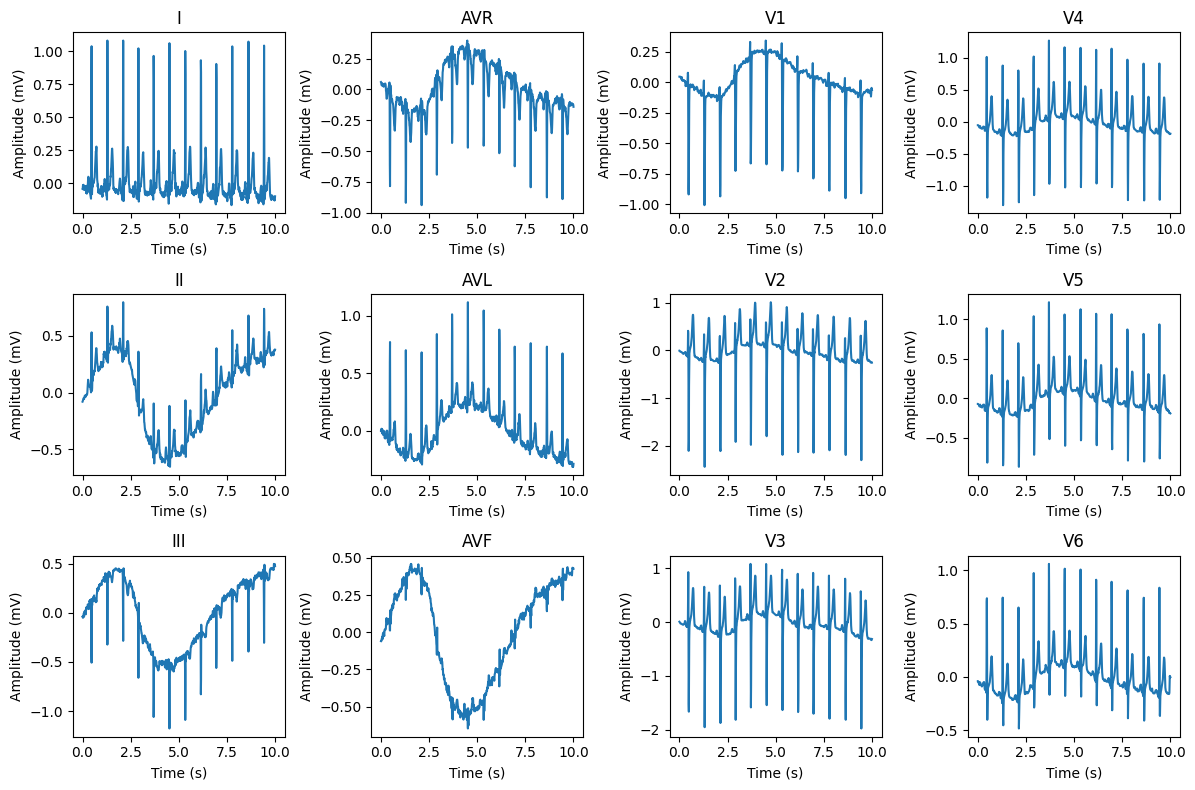

Data issues:
  - baseline drift:  , II,AVF
  - static noise:  , I-AVF,  
  - burst noise: nan
  - electrode problems: nan


In [76]:
# Get ECG of Myocardial Infarction for exploration
MI_metadata = metadata[metadata['MI']==1]
filename = MI_metadata.iloc[0].filename_lr
data, meta = load_data(filename, data_dir)
print('Diagnostic:', MI_metadata.iloc[0]['diagnostic_superclass'])
plot_ecg(data, meta)
print('Data issues:')
print('  - baseline drift:', MI_metadata.iloc[0]['baseline_drift'])
print('  - static noise:', MI_metadata.iloc[0]['static_noise'])
print('  - burst noise:', MI_metadata.iloc[0]['burst_noise'])
print('  - electrode problems:', MI_metadata.iloc[0]['electrodes_problems'])

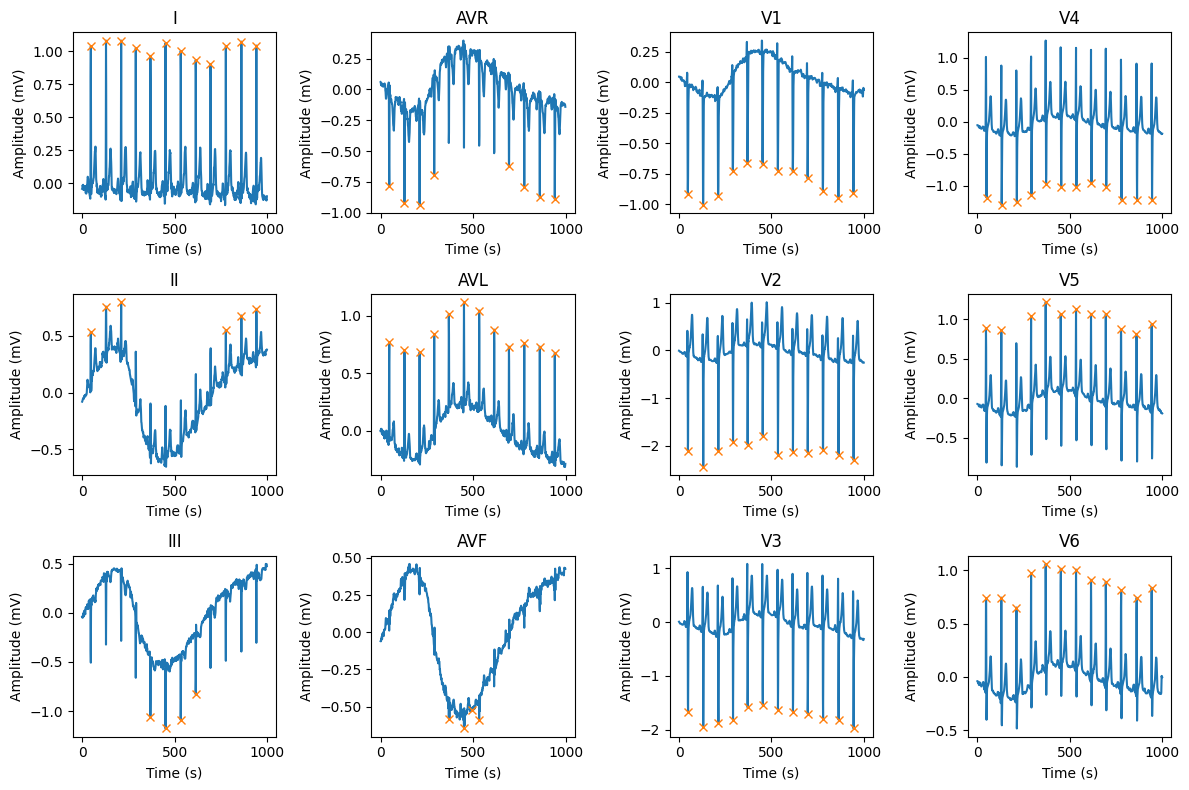

Lead      Heart rate
I         73.74301675977652
II        33.51955307262569
III       73.46938775510203
AVR       46.927374301675975
AVL       73.74301675977652
AVF       111.80124223602485
V1        73.74301675977652
V2        73.66071428571428
V3        73.74301675977652
V4        73.74301675977652
V5        66.96428571428571
V6        73.74301675977652


In [77]:
# Calculate and print heart rate for each lead, along with R-peaks plot
hr_dict = calculate_heart_rate(data, meta, plot=True)

# Modeling

After looking at the data as an ML Engineer, I thought that it would be interesting to implement a simple deep learning model to **distinguish between normal ECG segments and Myocardial Infarction** ECG segments.

Besides, I thought it would be useful to not only observe these classification results but also **understand which ECG channels most contribute to the results**. Contrary to the work of Zhang et al. [1], which includes an interpretability module to understand the best-performing leads, in this work the same is achieved by the network itself. This network applies a **feature extraction step to each channel separately**, which consists of a set of convolutional layers followed by ReLU activations and max pooling and a linear layer at the end. The features extracted for each channel are then concatenated and the **12 final features** are then fed to a linear layer to obtain the diagnosis outcome. This last linear layer is what will allow the study of the **weights associated with each lead** since each neuron corresponds to one only lead.

## Data preparation

On the data preparation phase, I selected only normal and Myocardial Infarction ECG segments and divided the data in **train-validation-test splits** for further use. Note that for time constraints, I only considered four splits for training.

In [ ]:
data_dir = '/content/drive/My Drive/Idoven/data/'

# Get metadata and labels
metadata = load_metadata(data_dir)

# Filter for normal and Myocardial Infarction conditions
metadata_filt = metadata[(metadata['MI']==1) | (metadata['NORM']==1)]

# Filter by folds of train-validation-test
train_folds = [1, 2, 3, 4]  # Folds 5, 6 and 7 were not used because of time constraints
val_fold = 9
test_fold = 10
metadata_train = metadata_filt[(metadata_filt['strat_fold'].isin(train_folds))]
metadata_val = metadata_filt[metadata_filt['strat_fold']==val_fold]
metadata_test = metadata_filt[metadata_filt['strat_fold']==test_fold]

metadata_train['labels'] = get_labels(metadata_train)
metadata_val['labels'] = get_labels(metadata_val)
metadata_test['labels'] = get_labels(metadata_test)

print('Train class distribution:')
print(metadata_train.labels.value_counts())

print('\nValidation class distribution:')
print(metadata_val.labels.value_counts())

print('\nTest class distribution:')
print(metadata_test.labels.value_counts())

Train class distribution:
0    3826
1    2166
Name: labels, dtype: int64

Validation class distribution:
0    956
1    541
Name: labels, dtype: int64

Test class distribution:
0    963
1    551
Name: labels, dtype: int64


In [ ]:
# Load and save splits data along with labels

train_data = load_all_data(data_dir, metadata_train)
train = train_data, list(metadata_train['labels'])
with open(os.path.join(data_dir, 'train_data.pkl'), 'wb') as f:
  pickle.dump(train, f)

val_data = load_all_data(data_dir, metadata_val)
val = val_data, list(metadata_val['labels'])
with open(os.path.join(data_dir, 'val_data.pkl'), 'wb') as f:
  pickle.dump(val, f)

test_data = load_all_data(data_dir, metadata_test)
test = test_data, list(metadata_test['labels'])
with open(os.path.join(data_dir, 'test_data.pkl'), 'wb') as f:
  pickle.dump(test, f)

## Train

The network was fully developed by me, not based on any literature work, only on a basic CNN architecture.

The implemented network was trained for **100 epochs** and both the best validation loss and accuracy checkpoints were saved. **Adam** was used as an optimizer together with **NLL loss**.

**Insights and conclusions:**

* Looking at the resulting graphs it can be observed that the **model is converging**, with some **overfit**. However, it appears that the metrics could still improve. The value of 100 epochs was arbitrary, in the future, this value should be increased and an early stopping technique should be employed to explore the full potential of this training step.

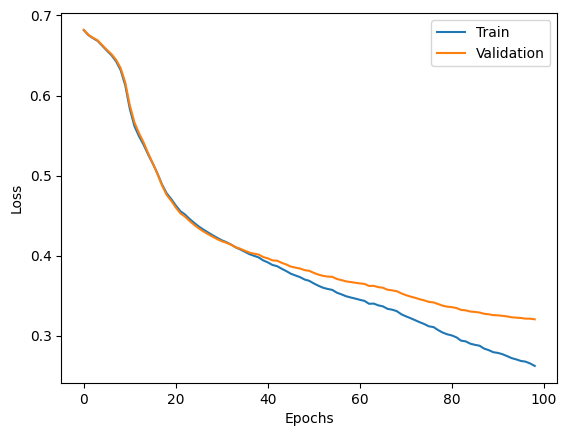

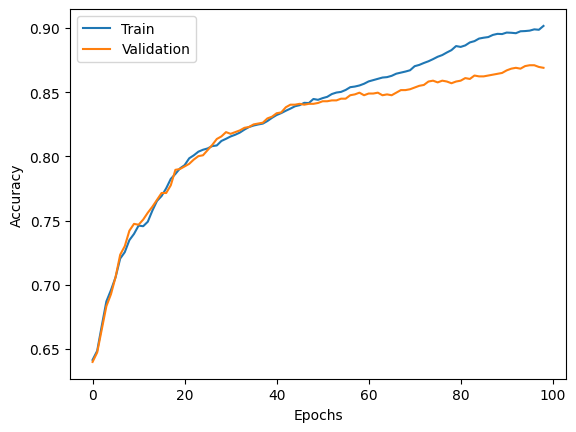

In [ ]:
# Initialize model, optimizer and loss/accuracy functions
batch_size = 32
model = Net().double()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-2)
loss_fn = nn.NLLLoss()
acc_fn = Accuracy(task='binary')

# Get train-validation dataloaders
data_dir = '/content/drive/My Drive/Idoven/data/'
train_dataset = CustomDataset(os.path.join(data_dir, 'train_data.pkl'))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataset = CustomDataset(os.path.join(data_dir, 'val_data.pkl'))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Get models dir
models_dir = '/content/drive/My Drive/Idoven/models/'

# Train model
n_epochs = 100
y_train_final, y_pred_train_final, y_val_final, y_pred_val_final, model = \
  train_dl(model, optimizer, loss_fn, acc_fn, n_epochs, train_loader, val_loader, models_dir)

## Results

This section intends to extract the results from the previously trained model on an unseen test dataset.

**Insights and conclusions:**

* We can observe that a very simple model as the one implemented is capable of achieving great results, with **86% of accuracy**.

* Here the weight of each ECG lead was assessed, concluding that **the lead that has the biggest influence on the output is by far lead III**, followed by leads II, V4 and V1. On the other hand, **leads V6 and I are of little importance** for the identification of Myocardial Infarction. This does not follow the conclusions taken by Zhang et al. [1]; however, not only their analysis is made for a set of cardiac conditions instead of only one, but also the dataset is not the same which can influence the results.

Best epoch: 95
Train loss: 0.26873199031186384
Train accuracy: 0.898030698299408
Validation loss: 0.3223721693989244
Validation accuracy: 0.8710755109786987 

Test accuracy: 0.8579920530319214


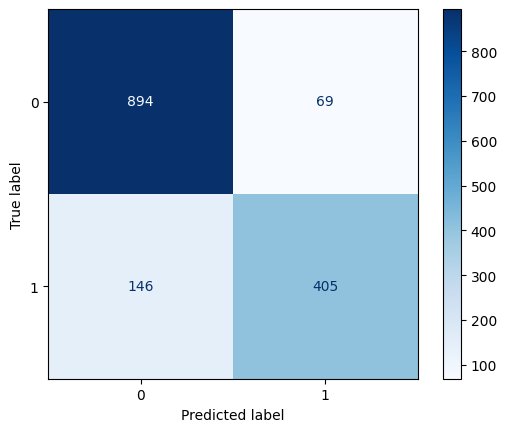

In [ ]:
# Get test dataloader
data_dir = '/content/drive/My Drive/Idoven/data/'
test_dataset = CustomDataset(os.path.join(data_dir, 'test_data.pkl'))
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Initialize accuracy function and model
acc_fn = Accuracy(task='binary')
model = Net().double()

# Get model's results
models_dir = '/content/drive/My Drive/Idoven/models/'
model = plot_dl_results(os.path.join(models_dir, 'acc_checkpoint.pt'), model, test_loader, acc_fn)

In [ ]:
# Print weight of each ECG channel

channels = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
for i, layer in enumerate(model.children()):
  if i == 6: # Last linear layer
    weights = layer.state_dict()['weight'].data[0]

pd.DataFrame({'Channels': channels, 'Weight': weights}).style.hide(axis='index')

Channels,Weight
I,-0.091736
II,-0.314179
III,0.454040
AVR,-0.109955
AVL,-0.138107
AVF,0.126019
V1,0.201753
V2,0.133205
V3,0.141922
V4,0.219667


# Final remarks

* In such a short amount of time, a very simple network was developed in order to distinguish between normal ECG segments and those with Myocardial Infarction. To fully take advantage of the data, this would need to be **escalated in order to englobe all cardiac conditions**. This is done in the literature in two different ways:
  1. By evaluating normal vs abnormal ECG signals, keeping the binary problem [2].
  2. By considering multiclass classification and keeping all cardiac conditions separate [1, 3].

* Also, this was done with no pre-processing of the ECG signals. This **pre-processing** could be considered for future approaches to remove possible baseline wander and noise.

* Moreover, **architecture explorations** could be explored to take the full potential out of the data. Again, this network is very simple in comparison to those found in the literature [1-3], which also has its advantages in training and inference time.

* Nevertheless, important **insights on the most important leads for this diagnosis** have been taken, which can influence future research developments as well as hardware for ECG collection considerations.

# References

[1] D. Zhang, S. Yang, X. Yuan, P. Zhang. Interpretable deep learning for automatic diagnosis of 12-lead electrocardiogram. *iScience*, vol., 2021.doi: 10.1016/j.isci.2021.102373.

[2] J. Zhu, J. Lv, D. Kong. CNN-FWS: A Model for the Diagnosis of Normal and Abnormal ECG with Feature Adaptive. *Entropy (Basel)*, 24(4):471, 2022. doi: 10.3390/e24040471.

[3] D. Feyisa, T. Debelee, Y. Ayano, S. Kebede, T. Assore. Lightweight Multireceptive Field CNN for 12-Lead ECG Signal Classification. *Computational Intelligence and Neuroscience*, vol. 2022, 2022. doi: 10.1155/2022/8413294.
